## RNNs MNIST

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

#print(os.listdir("../input"))

In [3]:
# Importing the dataset
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


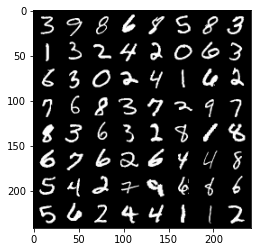

In [4]:
# Exploring the dataset

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [11]:
# RNN Model
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        #print(X.size())

        # transforms X to dimensions: n_steps by batch_size by n_inputs
        X = X.permute(1, 0, 2) 

        #print("permute step", X.size())
        
        self.batch_size = X.size(1) #which is 64 
        self.hidden = self.init_hidden()

        #print("self hidden size", self.hidden.size())
        
        #print("\n OUTPUT")
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      

        #basic_rnn takes in 

        #print("lstm out", lstm_out.size())
        #print("self.hidden size", self.hidden.size())

        out = self.FC(self.hidden)

        #print("out", self.FC(self.hidden).size())
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [12]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

# Instantiate model
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
#print(logits[0:10])

In [13]:
images.view(-1, 28,28).size()

torch.Size([64, 28, 28])

In [14]:
logits = model(images.view(-1, 28,28))
print(logits.size())

torch.Size([64, 10])


In [20]:
'''
# Training
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
'''

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        #outputs are [64, 10]
        #labels are [64] 

        print(outputs)
        print(labels)

        break
    
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

tensor([[-5.2262e-01,  6.1376e-01, -3.6417e-01, -2.2255e-01,  1.5730e-01,
          7.8299e-01,  4.5883e-01, -3.4124e+00,  5.7132e+00, -9.3037e-01],
        [-6.8885e+00,  1.3158e+00, -6.7292e-01,  3.9343e+00, -1.1442e+00,
          1.6203e+00, -5.7886e+00,  7.6496e-01,  1.3084e-01,  4.7325e+00],
        [-1.1398e+00, -3.4945e+00, -1.6222e+00, -1.7478e+00,  6.5438e+00,
          2.4446e-01, -9.1751e-02, -9.4255e-01,  9.6661e-01,  4.1524e+00],
        [ 8.8585e+00, -4.6020e+00,  7.9869e-01, -5.6246e-01, -3.7425e+00,
          2.1147e+00, -1.1814e+00, -5.6394e-01,  1.8175e+00, -1.1737e+00],
        [-4.4864e+00,  7.5010e+00,  6.5301e-01,  1.2875e+00,  7.2539e-02,
         -2.9275e+00, -2.2957e+00, -3.6493e-01,  2.1111e+00, -1.1662e+00],
        [ 8.9195e+00, -5.0421e+00,  2.8082e+00, -1.3942e+00, -1.3897e+00,
          6.8887e-01,  1.1967e+00, -2.4578e+00,  2.7870e-01, -1.6817e+00],
        [-2.2078e+00,  1.3961e+00,  1.8912e+00,  7.0555e+00, -5.2638e+00,
          1.8105e+00, -3.8100e+0

ZeroDivisionError: float division by zero

In [16]:
# Calculate test accuracy
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 92.85
